<img src="https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/gettyimages-684098860-ii-1558361781.jpg?crop=0.667xw:1.00xh;0.0586xw,0&resize=980:*" style="float: left; margin: 20px; height: 200px">

# American Dreaming:

### Using Machine Learning to Predict Home Pricing During Economic Uncertainty

*by Ashanti Jabri*

---

### Problem Statement

Across the country, housing prices are rising like never before - and faster than ever.

The *S&P CoreLogic Case-Shiller National Home Price NSA Index*, which tracks price changes of single-family homes, indicates that in November 2020, housing prices had risen 9.5 percent from the previous November. At the end of 2019, the average home was worth around \\$245,000. It’s now worth more than \$266,000, according to Zillow estimates.

This raises some serious questions about what our economy is doing, and why. The unemployment rate jumped in April 2020 to a level not seen since the 1930s — and still stood at 6.3 percent in January 2021. So where are people getting the money to buy homes? Why do they feel comfortable doing so? And what makes home sellers so confident that their homes will sell at increased rates during a global pandemic?

The saying goes that the market always corrects itself, but at what cost? We know that some of the factors behind the spike in home prices are due largely in part to all-time low-interest rates, and a ripe secondary market taking advantage of incredibly cheap mortgage-backed securities. This has created a sweet spot of sorts between supply and demand for homes, that has all the makings for a bursting bubble culminating with a massive refinance boom. 

The question for realtors, home buyers, sellers, and appraisers, then becomes "What are the proper metrics and criteria for pricing a home?" At this current time, following market trends make sense; do what your neighbors are doing, what your competitors are doing, and rake in the profits. But that is not a sustainable long-term strategy. Either housing prices continue to rise, as will inflation, or the market will correct itself, and we'll have to adapt to a new norm.

I hypothesize that currently, economic uncertainty has little effect on the overall housing market's profitability, and by being able to accurately predict house price in the form of a percentage relative to the mean of the national annual house price report of comparables, we will be able to account for future home price trends, given interest rate estimates. I will be using the Ames, Iowa housing dataset to make my predictions. This is a data set of single family homes sold between the years 2006-2010. This is extremely important for the success of our project, as being able to compare home pricing trends during the 2008 financial crisis will give us an even stronger basis for our hypothesis. We will be building a linear regression model for our predictions and analysis.


----

### Data Sets

* [`ames_clean`](./datasets/ames_clean.csv): Ames, Iowa Housing Data
* [`Interest Rates`](./datasets/rates.dta): Interest Rates From 1959 to 2014
* [`Unemployment Rates`](./datasets/unemployment_2020.xlsx): 2020 Unemployment Rates
* [`US_House_Data`](./datasets/us_house_data.csv): Annual Zillow House Prices

### Contents:
- [Data Cleaning](#Data-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Modeling](#Modeling)
- [Lasso CV](#Lasso-CV)

# Importing Libraries and Data
----

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, Lasso, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import statsmodels.api as sm

ames = pd.read_csv('./datasets/train.csv')
int_rate = pd.read_stata('./datasets/rates.dta')
house_data = pd.read_csv('./datasets/us_house_data.csv')
unem_rate = pd.read_excel('./datasets/unemployment_2020.xlsx')

/Users/yungpastorphillipswift/ana3/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:214: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


# Data Cleaning

The data was full of null values, ordinal and catergorical values, and unnecesary values. Many features worked best together, as opposed to by themselves, and many features were in direct contrast to each other when not made into interaction terms. Cleaning was done throughout the project at every stage and I organized all of it here in this section to make the note book more intelligable.

-----

In [3]:
ames_id_for_kaggle = ames['Id']
ames.drop(columns =['Id', 'PID'], inplace = True)
ames.loc[ames['Lot Frontage'].isnull(), 'Lot Frontage'] = ames['Lot Frontage'].mean()

In [4]:
def fix_null(df,train_df):
   
    
    categorical = ['Pool QC','Misc Feature','Alley','Fence','Fireplace Qu','Garage Type','Garage Finish',
                   'Garage Cond','BsmtFin Type 2','Bsmt Exposure','BsmtFin Type 1','Bsmt Cond','Bsmt Qual',
                   'Mas Vnr Type']
    for col in categorical:
        df[col] = df[col].fillna('None')

    
    numerical = ['Garage Yr Blt','Garage Qual','Mas Vnr Area','Bsmt Half Bath','Bsmt Full Bath','Garage Area',
                 'Garage Cars','Total Bsmt SF','Bsmt Unf SF','BsmtFin SF 2','BsmtFin SF 1']
    for col in numerical:
        df[col] = df[col].fillna(0)
        
    
    few = ['Electrical','MS Zoning','Utilities','Sale Type','Kitchen Qual','Exterior 2nd','Exterior 1st']
    for col in few:
        df[col] = df[col].fillna(train_df[col].mode()[0])
    
    
    df['Functional'] = df['Functional'].fillna('Typ')

        
    return df

In [5]:
ames = fix_null(ames,ames)
ames['has_garage'] = [1 if x > 0 else 0 for x in ames['Garage Area']]
ames['has_pool'] = [1 if x > 0 else 0 for x in ames['Pool Area']]
ames['has_fireplace'] = [1 if x > 0 else 0 for x in ames['Fireplaces']]
ames['has_open_porch'] = [1 if x > 0 else 0 for x in ames['Open Porch SF']]
ames['has_bsmt'] = [1 if x > 0 else 0 for x in ames['Total Bsmt SF']]
ames['bsmt_bath'] = ames['Bsmt Full Bath'] + ames['Bsmt Half Bath']
ames['bathrooms'] = ames['Full Bath'] + ames['Half Bath']

In [6]:
conv_nums =  {'NA':1, 'Po':2, 'Fa':4, 'TA':6, 'Gd':8, 'Ex':10,'Gd':4,'Av':3,'Mn':2,'No':1,'GLQ':7,
              'ALQ':6,'BLQ':5,'Rec':4,'LwQ':3,'Unf':2,'Fin':3,'RFn':2,'Unf':1, 'Reg': 4, 'IR1':3,
              'IR2':2, 'IR3':1, 'AllPub':4, 'NoSewr':3, 'NoSeWa':2, 'ELO': 1, 'Gtl':3, 'Mod':2, 'Sev':1
             }

In [7]:
ames['Land Slope'] = ames['Land Slope'].map(conv_nums)
ames['Lot Shape'] = ames['Lot Shape'].map(conv_nums)
ames['Utilities'] = ames['Utilities'].map(conv_nums)
ames['Exter Qual'] = ames['Exter Qual'].map(conv_nums)
ames['Bsmt Qual'] = ames['Bsmt Qual'].map(conv_nums)
ames['Bsmt Exposure'] = ames['Bsmt Exposure'].map(conv_nums)
ames['BsmtFin Type 1'] = ames['BsmtFin Type 1'].map(conv_nums)
ames['Heating QC'] = ames['Heating QC'].map(conv_nums)
ames['Kitchen Qual'] = ames['Kitchen Qual'].map(conv_nums)
ames['Garage Finish'] = ames['Garage Finish'].map(conv_nums)
ames.fillna(0, inplace = True)

----
# Exploratory Data Analysis

The EDA was the point in which I discovered the most aggregious cleaning errors. Here are the graphs used to decipher outliers and column correlations. 

----

In [8]:
ames_clean = pd.read_csv('./datasets/ames_clean.csv')

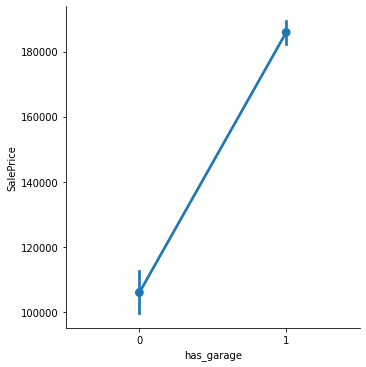

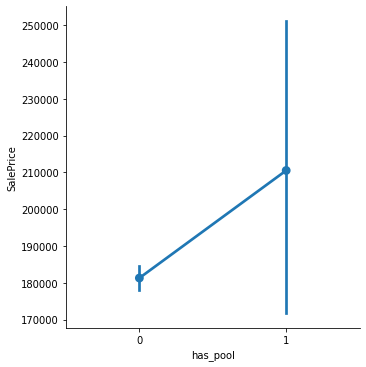

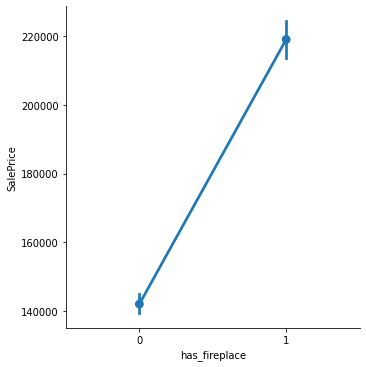

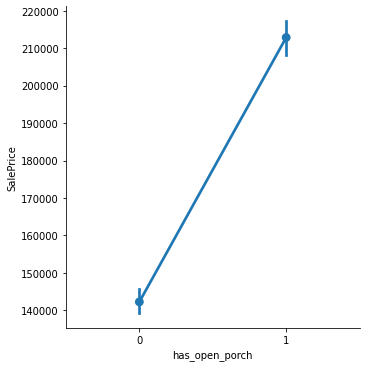

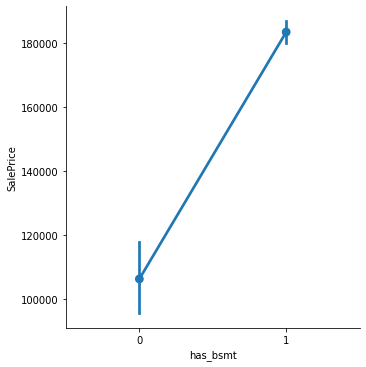

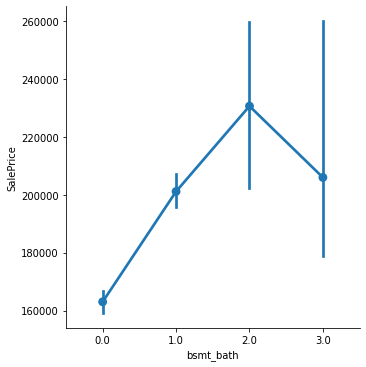

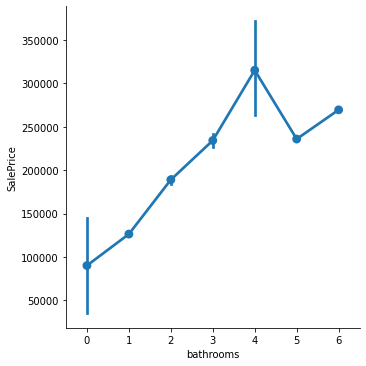

In [9]:
sns.catplot(data=ames_clean, x ='has_garage', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='has_pool', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='has_fireplace', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='has_open_porch', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='has_bsmt', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='bsmt_bath', y='SalePrice', kind='point')
sns.catplot(data=ames_clean, x ='bathrooms', y='SalePrice', kind='point')

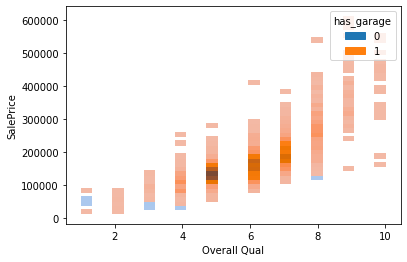

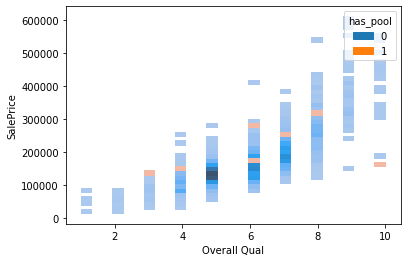

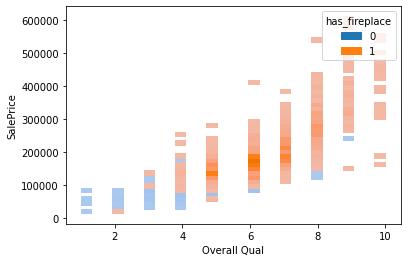

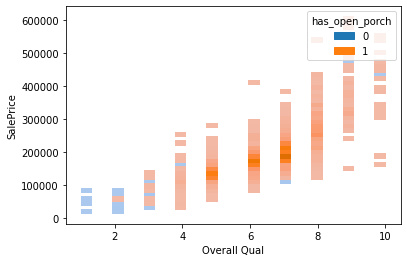

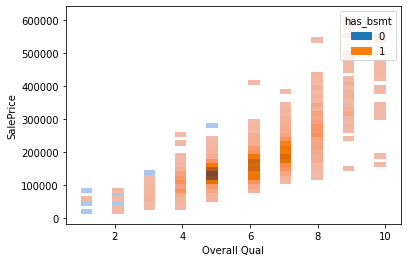

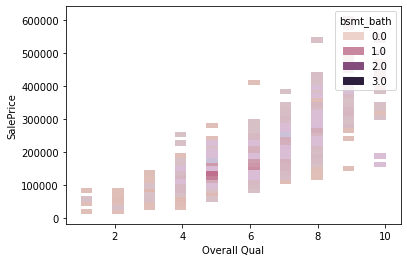

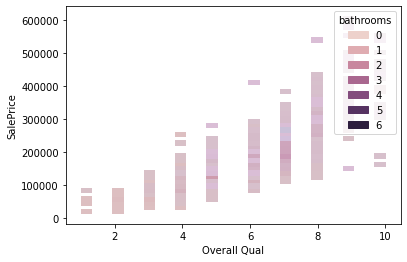

In [10]:
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'has_garage');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'has_pool');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'has_fireplace');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'has_open_porch');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'has_bsmt');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'bsmt_bath');
plt.figure()
sns.histplot(data=ames, x ='Overall Qual', y='SalePrice', hue = 'bathrooms');

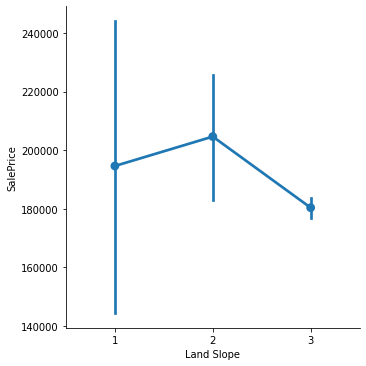

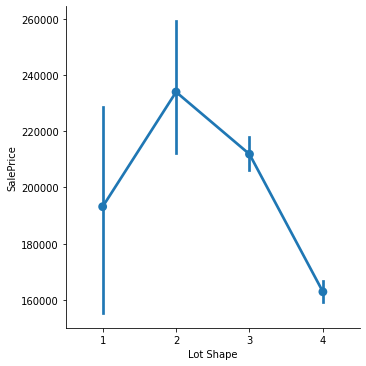

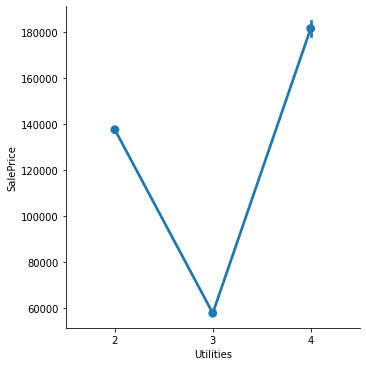

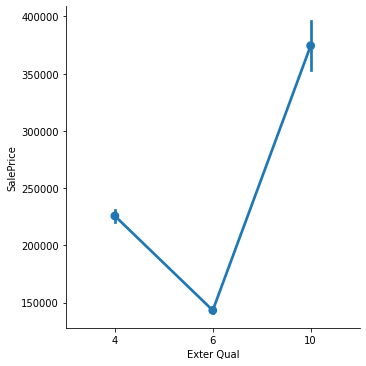

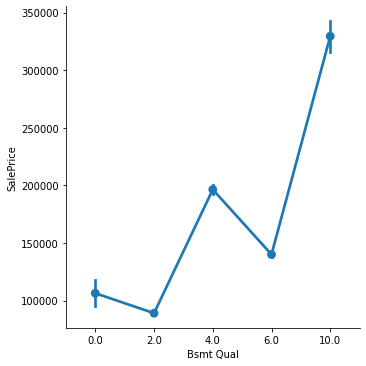

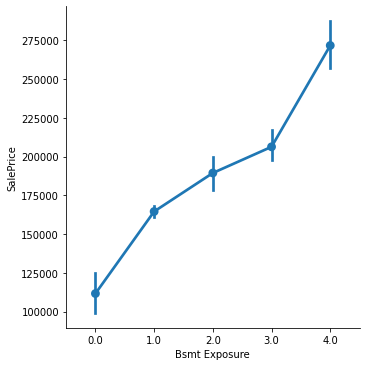

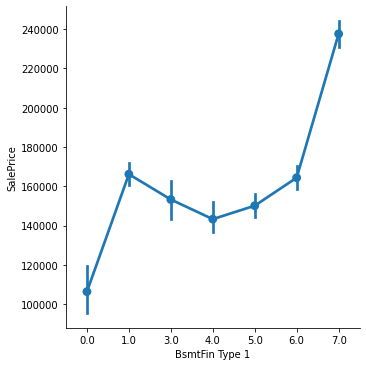

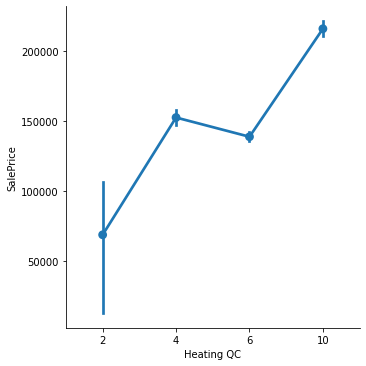

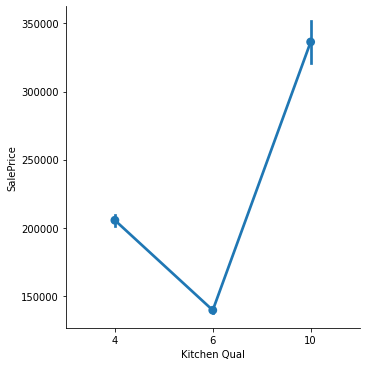

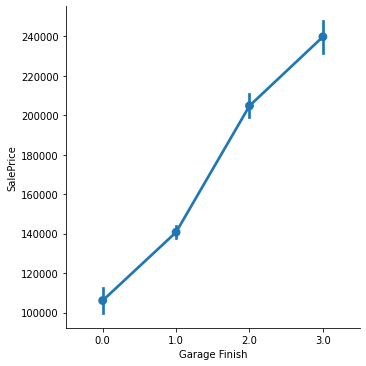

In [11]:
sns.catplot(data=ames_clean, x ='Land Slope', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Lot Shape', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Utilities', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Exter Qual', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Bsmt Qual', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Bsmt Exposure', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='BsmtFin Type 1', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Heating QC', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Kitchen Qual', y='SalePrice', kind='point');
sns.catplot(data=ames_clean, x ='Garage Finish', y='SalePrice', kind='point');

<AxesSubplot:xlabel='Gr Liv Area', ylabel='SalePrice'>

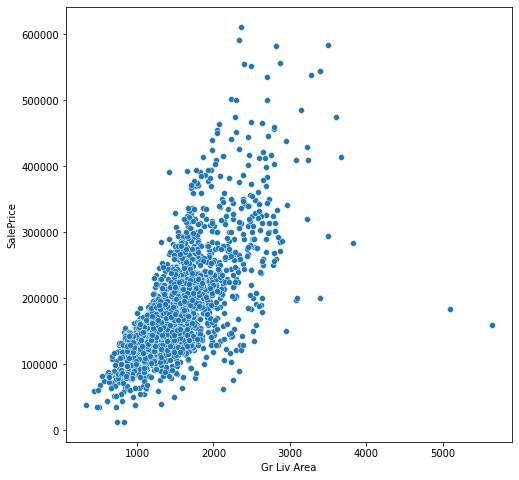

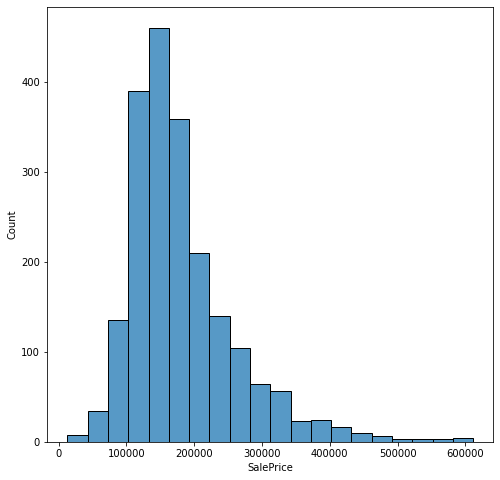

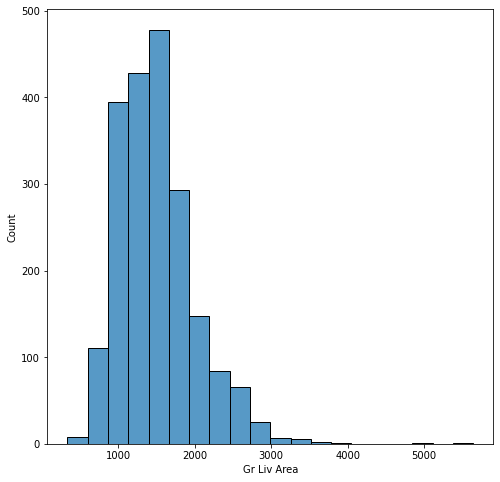

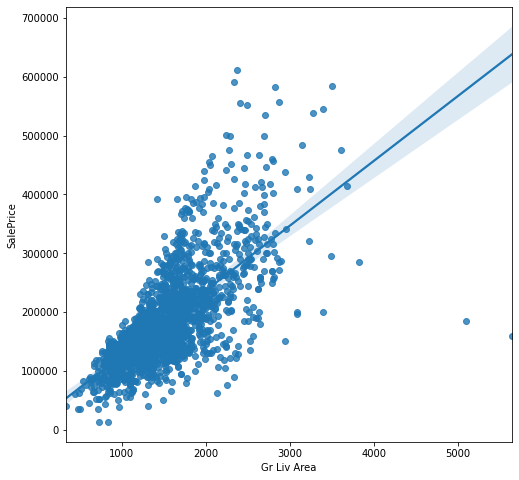

In [12]:
plt.figure(figsize=(8,8))
sns.scatterplot(data = ames_clean, x='Gr Liv Area', y='SalePrice', x_bins = 20, y_bins = 20);

plt.figure(figsize=(8,8))
sns.histplot(ames['SalePrice'], bins = 20);

plt.figure(figsize=(8,8))
sns.histplot(ames_clean['Gr Liv Area'], bins = 20);

plt.figure(figsize=(8,8))
sns.regplot(data = ames_clean, x='Gr Liv Area', y='SalePrice')

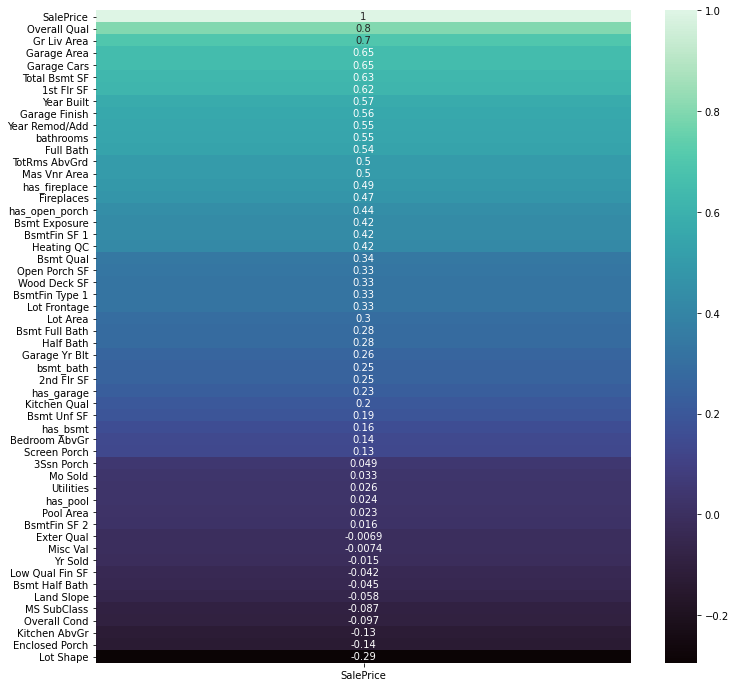

<Figure size 1440x1080 with 0 Axes>

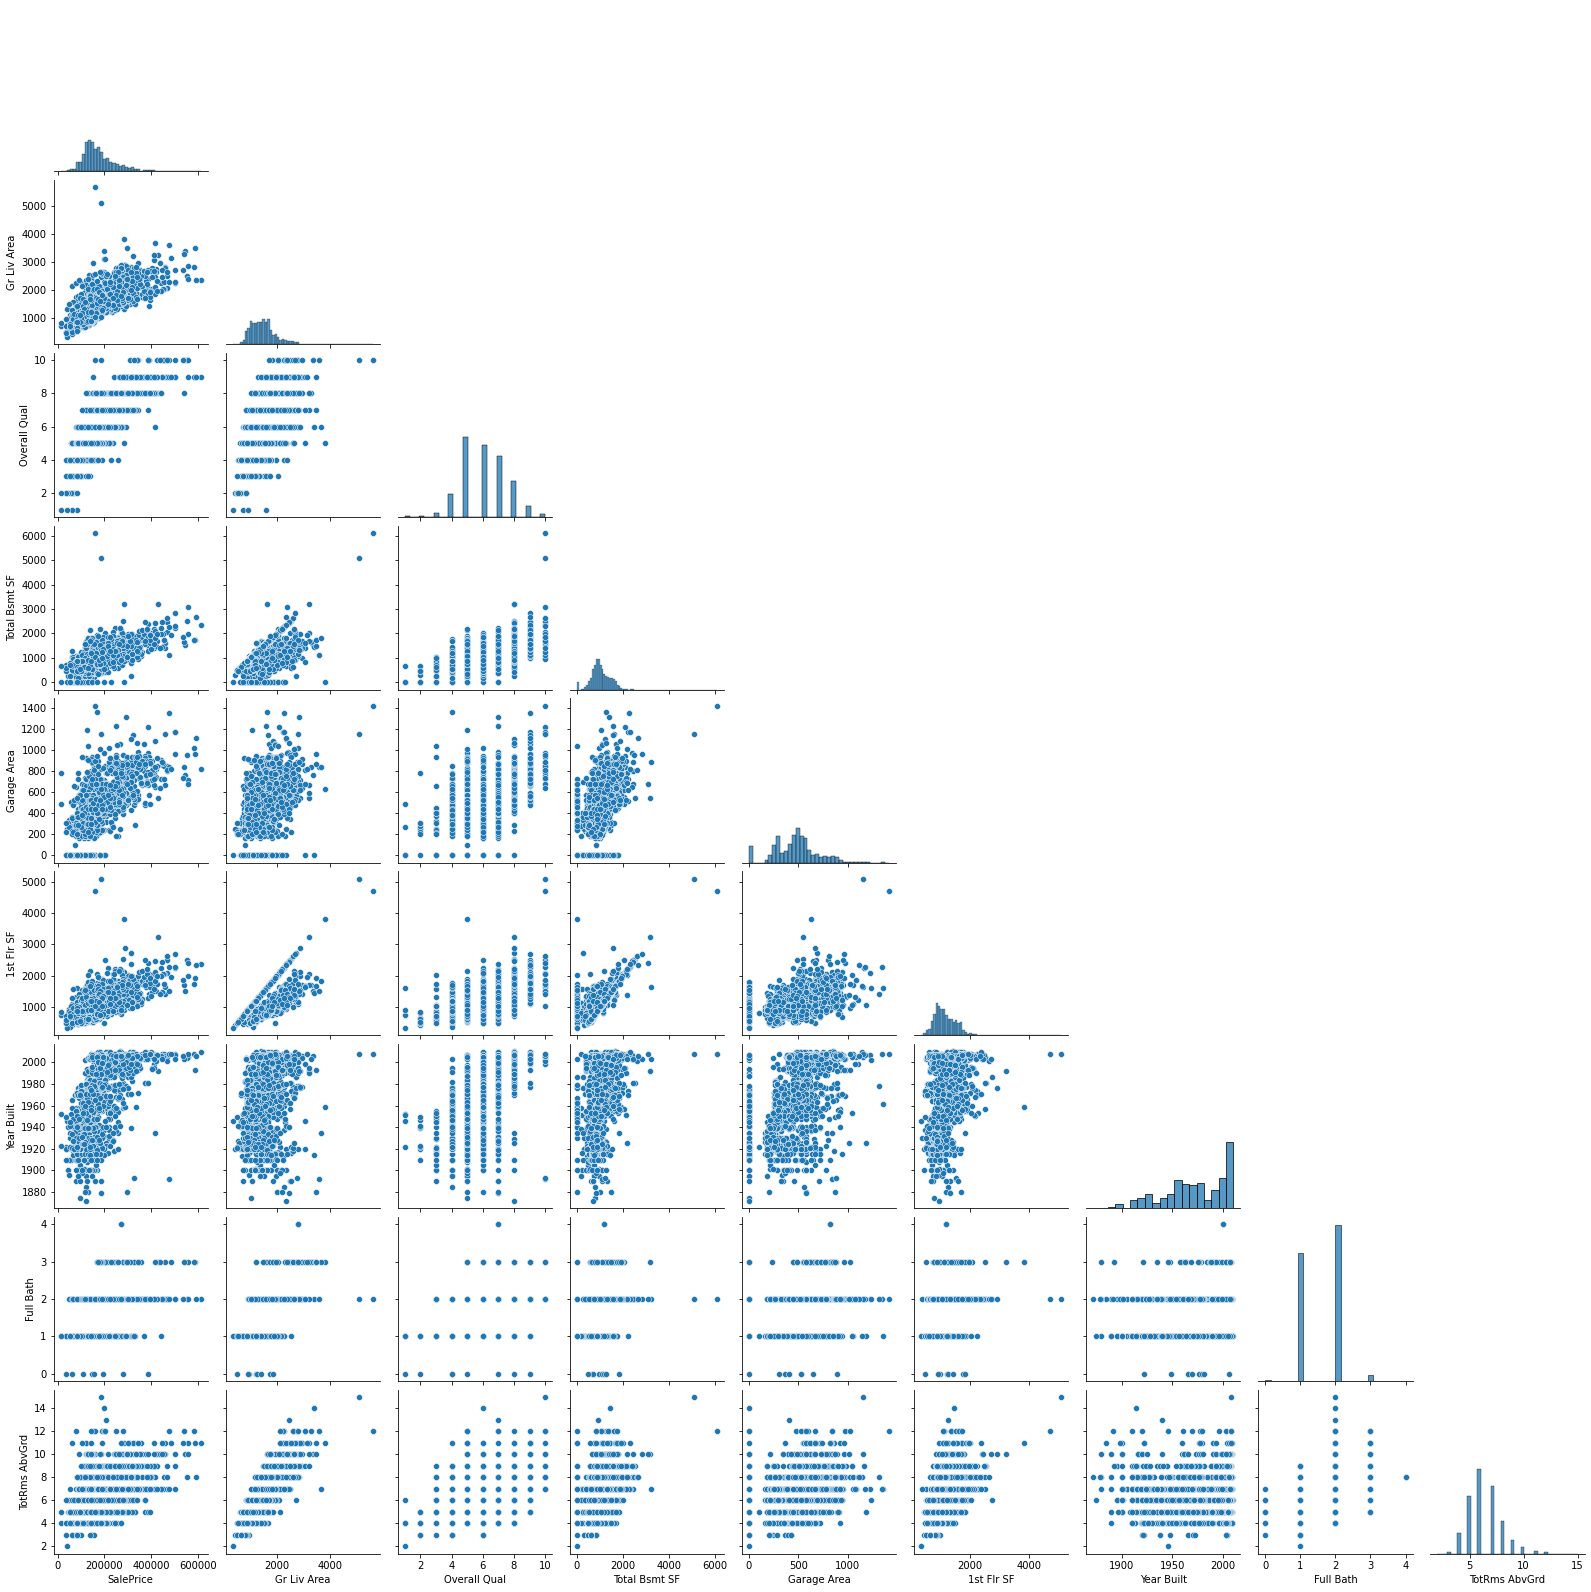

In [13]:
corr = ames_clean.corr()
plt.figure(figsize=(12,12))

sns.heatmap(corr[['SalePrice']].sort_values('SalePrice',ascending = False),
           annot=True, cmap = 'mako');

# plt.savefig('./features heatmap.png', transparent = True, dpi = 400)
plt.figure(figsize=(20,15))

sns.pairplot(ames_clean, vars=['SalePrice', 'Gr Liv Area', 'Overall Qual', 'Total Bsmt SF', 'Garage Area',
                              '1st Flr SF', 'Year Built', 'Full Bath', 'TotRms AbvGrd'], corner = True);

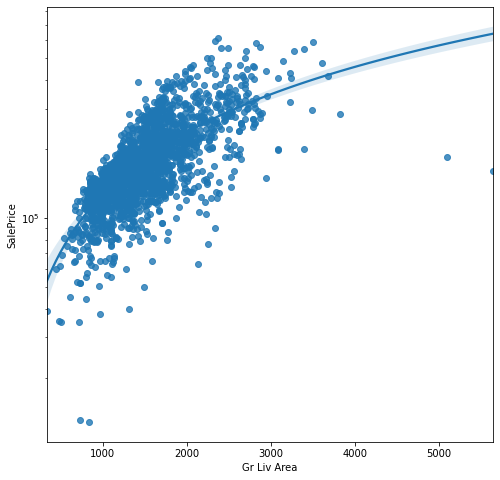

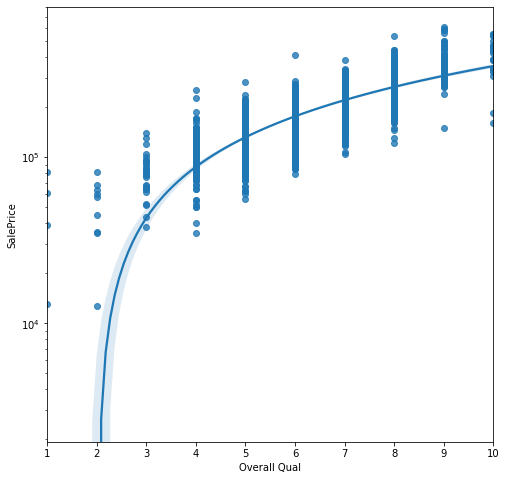

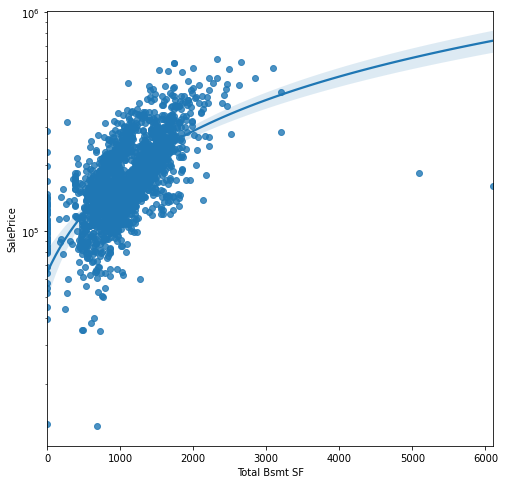

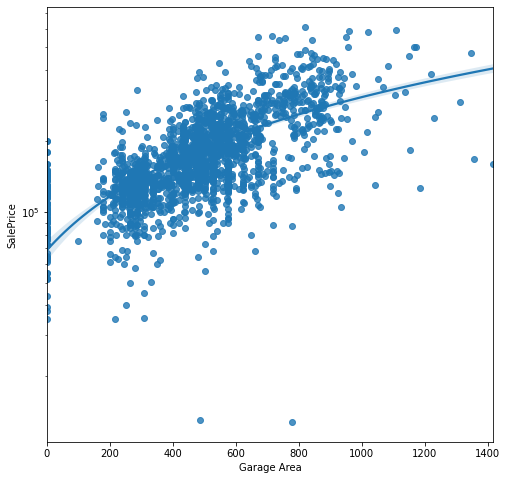

<Figure size 576x576 with 0 Axes>

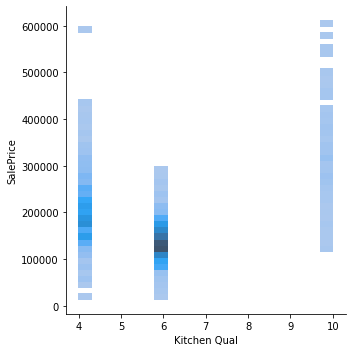

In [14]:
plt.figure(figsize=(8,8))
ax = sns.regplot(data = ames_clean, x='Gr Liv Area', y='SalePrice')
ax.set_yscale('log')
plt.figure(figsize=(8,8))
ax = sns.regplot(data = ames_clean, x='Overall Qual', y='SalePrice')
ax.set_yscale('log')
plt.figure(figsize=(8,8))
ax = sns.regplot(data = ames_clean, x='Total Bsmt SF', y='SalePrice')
ax.set_yscale('log')
plt.figure(figsize=(8,8))
ax = sns.regplot(data = ames_clean, x='Garage Area', y='SalePrice')
ax.set_yscale('log')
plt.figure(figsize=(8,8))
ax = sns.displot(data = ames_clean, x='Kitchen Qual', y='SalePrice')
plt.show();

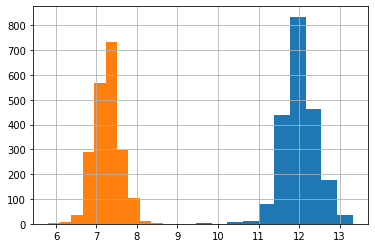

In [15]:
ames_clean['SalePrice'].apply(np.log).hist()
ames_clean['Gr Liv Area'].apply(np.log).hist()
plt.show()

In [16]:
ames_clean.drop(index=[960,1885], axis=0, inplace=True) 
ames_clean.drop(index=[1566,1605], axis=0, inplace=True)
ames_clean.drop(index=[1147], axis=0, inplace=True) 
ames_clean.drop(index=[1939], axis=0, inplace=True) 
ames_clean.drop(index=[616,1243], axis=0, inplace=True) 
ames_clean.drop(index=[183,1628], axis=0, inplace=True) 
ames_clean.drop(index=[1964], axis=0, inplace=True) 

----
# Modeling

I created a few different models to get the best score, and used polynomial features and lassoCV, but in the end OLS proved to be the best model for our regression.
____

In [30]:
x_vars = ames_clean._get_numeric_data().columns.drop(['BsmtFin Type 1', 'Land Slope', 'Utilities', 'Half Bath', 'Garage Finish',
 'has_garage', 'has_pool', 'has_fireplace', 'has_open_porch',
 'bsmt_bath', 'bathrooms', 'SalePrice'])

X = ames_clean[x_vars]

X = sm.add_constant(X)
y = np.log(ames_clean['SalePrice'])
results = sm.OLS(y,X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     530.9
Date:                Mon, 08 Mar 2021   Prob (F-statistic):               0.00
Time:                        09:43:41   Log-Likelihood:                 1463.9
No. Observations:                2040   AIC:                            -2846.
Df Residuals:                    1999   BIC:                            -2615.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              12.7627      4.138      3.084      0.002       4.647      20.879
MS SubClass        -0.0003   8.13e-05     -3.367      0.001      -0.000      -0.000
Lot Frontage        0.0008      0.000      4.680      0.000       0.000       0.001
Lot Area         2.933e-06   4.89e-07      5.999      0.000    1.97e-06    3.89e-06
Lot Shape          -0.0109      0.005     -2.096      0.036      -0.021      -0.001
Overall Qual        0.0714      0.003     20.772      0.000       0.065       0.078
Overall Cond        0.0492      0.003     16.383      0.000       0.043       0.055
Year Built          0.0032      0.000     18.521      0.000       0.003       0.004
Year Remod/Add      0.0013      0.000      6.367      0.000       0.001       0.002
Mas Vnr Area     -2.24e-05   1.86e-05     -1.204      0.229   -5.89e-05    1.41e-05
Exter Qual          0.0028      0.003      1.114      0.266      -0.002       0.008
Bsmt Qual           0.0074      0.002      3.911      0.000       0.004       0.011
Bsmt Exposure       0.0111      0.003      3.642      0.000       0.005       0.017
BsmtFin SF 1     7.535e-05   7.81e-06      9.650      0.000       6e-05    9.07e-05
BsmtFin SF 2     2.083e-05   1.32e-05      1.576      0.115   -5.09e-06    4.68e-05
Bsmt Unf SF      5.792e-06   7.42e-06      0.781      0.435   -8.75e-06    2.03e-05
Total Bsmt SF       0.0001   1.27e-05      8.016      0.000     7.7e-05       0.000
Heating QC          0.0060      0.001      4.679      0.000       0.003       0.008
1st Flr SF          0.0001   1.84e-05      5.496      0.000    6.49e-05       0.000
2nd Flr SF       9.898e-05   1.52e-05      6.531      0.000    6.93e-05       0.000
Low Qual Fin SF -3.398e-05   4.06e-05     -0.837      0.403      -0.000    4.56e-05
Gr Liv Area         0.0002   1.62e-05     10.218      0.000       0.000       0.000
Bsmt Full Bath      0.0267      0.008      3.519      0.000       0.012       0.042
Bsmt Half Bath     -0.0003      0.011     -0.025      0.980      -0.023       0.022
Full Bath           0.0195      0.008      2.570      0.010       0.005       0.034
Bedroom AbvGr      -0.0099      0.005     -1.998      0.046      -0.020      -0.000
Kitchen AbvGr      -0.0688      0.017     -4.120      0.000      -0.102      -0.036
Kitchen Qual        0.0054      0.002      2.621      0.009       0.001       0.009
TotRms AbvGrd       0.0055      0.004      1.482      0.139      -0.002       0.013
Fireplaces          0.0349      0.005      6.664      0.000       0.025       0.045
Garage Yr Blt    2.286e-05   7.94e-06      2.877      0.004    7.28e-06    3.84e-05
Garage Cars         0.0186      0.009      2.070      0.039       0.001       0.036
Garage Area       6.11e-05   3.01e-05      2.031      0.042    2.11e-06       0.000
Wood Deck SF      3.47e-05   2.33e-05      1.489      0.137

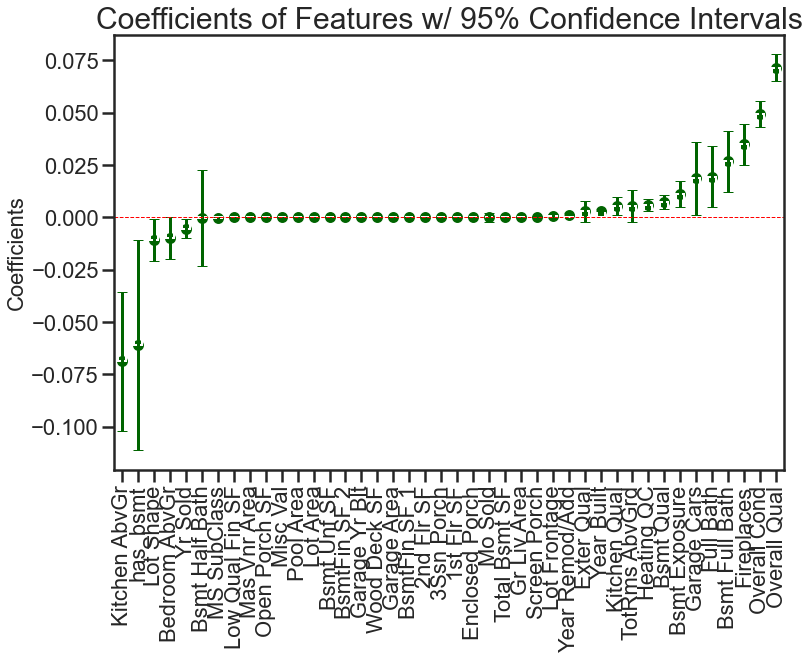

In [49]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='darkgreen',capsize=5,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=18)
    
    # Coefficients
    ax.scatter(x=np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='darkgreen')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
#     plt.savefig('./assets/coefs graph.png', transparent = True, dpi = 360, bbox_inches = 'tight');
    return plt.show()
coefplot(results)

In [18]:
x_vars = ames_clean._get_numeric_data().columns.drop(['BsmtFin Type 1', 'Land Slope', 'Utilities', 'Half Bath', 'Garage Finish',
 'has_garage', 'has_pool', 'has_fireplace', 'has_open_porch',
 'bsmt_bath', 'bathrooms', 'SalePrice'])

X = ames_clean[x_vars]

y = np.log(ames_clean['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=808)
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [19]:
r2_train = lr.score(X_train, y_train)
r2_test = lr.score(X_test, y_test)
cv_train = cross_val_score(lr, X = X_train, y = y_train).mean()
cv_test = cross_val_score(lr, X = X_test, y = y_test).mean()
rmse_train = metrics.mean_squared_error(np.exp(y_train), np.exp(lr.predict(X_train)), squared = False)
rmse_test = metrics.mean_squared_error(np.exp(y_test), np.exp(lr.predict(X_test)), squared = False)
null_model = metrics.mean_squared_error(np.exp(y_train), [np.exp(y_train.mean())] * len(y_train), squared = False)

print(f'The Null Model was: {null_model}')
print(f'The R2 score for the training set is: {r2_train}')
print(f'The R2 score for the testing set is: {r2_test}')
print(f'The Cross Val score for the training set is: {cv_train}')
print(f'The Cross Val score for the testing set is: {cv_test}')
print(f'The RMSE for the training set is: {rmse_train}')
print(f'The RMSE for the testing set is: {rmse_test}')

The Null Model was: 81241.01317162355
The R2 score for the training set is: 0.9141483399823884
The R2 score for the testing set is: 0.9086921250721309
The Cross Val score for the training set is: 0.9056381353202598
The Cross Val score for the testing set is: 0.891143916943868
The RMSE for the training set is: 21251.4834168086
The RMSE for the testing set is: 19702.909359036057


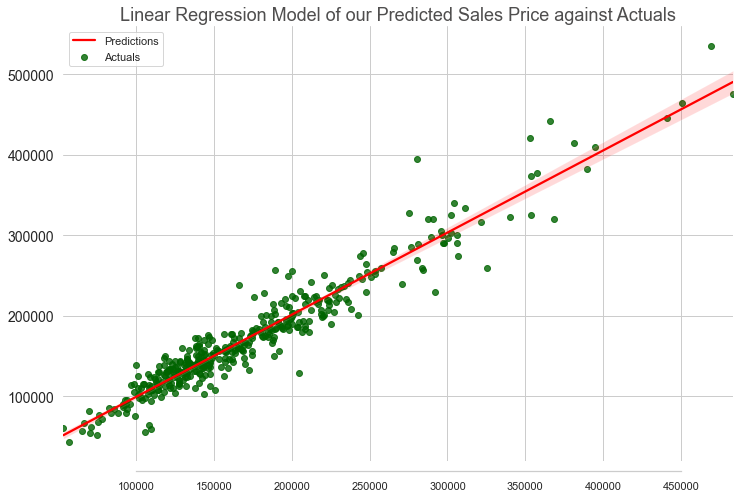

In [20]:
plt.figure(figsize=(12,8))
sns.set(style="whitegrid")
label = ['Predictions', 'Actuals']
sns.regplot(x = np.exp(lr.predict(X_test)), y = np.exp(y_test), color = 'darkgreen', line_kws={'color': 'red'}, label = label)
plt.legend(label)
plt.ylabel('')
plt.xticks(size=14)
plt.yticks(size=14)
plt.title('Linear Regression Model of our Predicted Sales Price against Actuals', size = 18, color = '#4f4e4e')
sns.despine(left=True,trim=True, offset = 10)

# plt.savefig('./Predictions graph.png', transparent = True, dpi = 500);

----
# Lasso CV
-----

In [21]:
x_vars = ames_clean._get_numeric_data().columns.drop(['BsmtFin Type 1', 'Land Slope', 'Utilities', 'Half Bath', 'Garage Finish',
 'has_garage', 'has_pool', 'has_fireplace', 'has_open_porch',
 'bsmt_bath', 'bathrooms', 'SalePrice'])

X = ames_clean[x_vars]

y = np.log(ames_clean['SalePrice'])

poly = PolynomialFeatures()
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size = 0.2, random_state = 42)

sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)
np.linspace(0.01, 100, 50)

ls = LassoCV(alphas = np.linspace(0.01, 100, 50) )
ls.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 2.05061224e+00, 4.09122449e+00, 6.13183673e+00,
       8.17244898e+00, 1.02130612e+01, 1.22536735e+01, 1.42942857e+01,
       1.63348980e+01, 1.83755102e+01, 2.04161224e+01, 2.24567347e+01,
       2.44973469e+01, 2.65379592e+01, 2.85785714e+01, 3.06191837e+01,
       3.26597959e+01, 3.47004082e+01, 3.67410204e+01, 3.87816327e+01,
       4.08222449e+01, 4.28628571e+0...
       4.89846939e+01, 5.10253061e+01, 5.30659184e+01, 5.51065306e+01,
       5.71471429e+01, 5.91877551e+01, 6.12283673e+01, 6.32689796e+01,
       6.53095918e+01, 6.73502041e+01, 6.93908163e+01, 7.14314286e+01,
       7.34720408e+01, 7.55126531e+01, 7.75532653e+01, 7.95938776e+01,
       8.16344898e+01, 8.36751020e+01, 8.57157143e+01, 8.77563265e+01,
       8.97969388e+01, 9.18375510e+01, 9.38781633e+01, 9.59187755e+01,
       9.79593878e+01, 1.00000000e+02]))

In [22]:
r2_lstrain = ls.score(Z_train, y_train)
r2_lstest = ls.score(Z_test, y_test)
rmse_lstest = metrics.mean_squared_error(np.exp(y_test), np.exp(ls.predict(Z_test)), squared = False)
rmse_lstrain = metrics.mean_squared_error(np.exp(y_train), np.exp(ls.predict(Z_train)), squared = False)

print(f'The R2 score for the Lasso training set is: {r2_lstrain}')
print(f'The R2 score for the Lasso testing set is: {r2_lstest}')
print(f'The RMSE for the training set is: {rmse_lstrain}')
print(f'The RMSE for the testing set is: {rmse_lstest}')

The R2 score for the Lasso training set is: 0.9080183246548617
The R2 score for the Lasso testing set is: 0.9105807500080355
The RMSE for the training set is: 21007.479522083086
The RMSE for the testing set is: 23246.005216076424
